# 第6回課題
前処理と特徴量選択により，SVM の最初のスコアよりも1割程度良いテストスコアを出してください．
ちょこっといじった程度では，線形回帰はスコアが変わらなかったので，参考程度に使ってください

### 必須事項
- 前処理：正規化，標準化，外れ値の排除など
- 特徴量選択: 検証は必須．増やす・減らす・変えないの結果は自由
- テストスコアの向上: mse で 0.41 くらいは出ると思います

### 自由事項
- 指標の変更
- パラメータの変更（モデルの変更は想定してません）

### 余談
特徴量選択で正解を用意するのは，やはり難しいなと解答を作る時に感じました．解答の方は最低限の考察と検証をしていますが，4時間かかりました( ;∀;)

## 注意事項
特徴量の分析時に分割したデータを使ってない時点でせこいというか，おかしいです．ここでは無視していますが，本来はできません．

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data):
- quality (score between 0 and 10)

In [2]:
wine_quality_df = pd.read_csv("winequality-red.csv",delimiter=";")
print(wine_quality_df.shape)
wine_quality_df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
wine_quality_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
feature_names = list(np.copy(wine_quality_df.columns))
feature_names.remove("quality")

In [5]:
X_train, X_test, y_train, y_test = \
    train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

## 注意
ここで，test score まで同時に出してしまっているんですが，1つの関数で実行してしまう方が楽だったという理由だけで，これらは分けた方が良いです．
パラメータや特徴量について考えるときには，CV だけで調整すべきです

In [6]:
kfold = KFold(n_splits=5, random_state=0)
def cross_validation(model, test=True):
    global X_train, X_test, y_train, y_test, feature_names
    scores = cross_val_score(model, X_train, y_train, cv=kfold, 
                             scoring=make_scorer(mean_squared_error))
    # 各分割におけるスコア
    print('Cross-Validation scores: {}'.format(scores))
    # スコアの平均値
    print('Average score: {}'.format(np.mean(scores)))
    if test:
        model.fit(X_train[feature_names], y_train)
        pred = model.predict(X_test[feature_names])
        print('Test score: {}'.format(mean_squared_error(y_test, pred)))

# モデルによる予測

In [7]:
linear_reg = Ridge(random_state=0)
cross_validation(linear_reg)

Cross-Validation scores: [0.48812538 0.48841541 0.42327305 0.42566563 0.36728215]
Average score: 0.43855232598926497
Test score: 0.40104663051541484


In [8]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.70535714 0.82142857 0.67857143 0.71875    0.56950673]
Average score: 0.6987227738629085
Test score: 0.5895833333333333


In [9]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.53300496 0.55297245 0.47889385 0.55125217 0.42733588]
Average score: 0.5086918627733359
Test score: 0.4598637954554451


# 以降にコードを追加

In [10]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

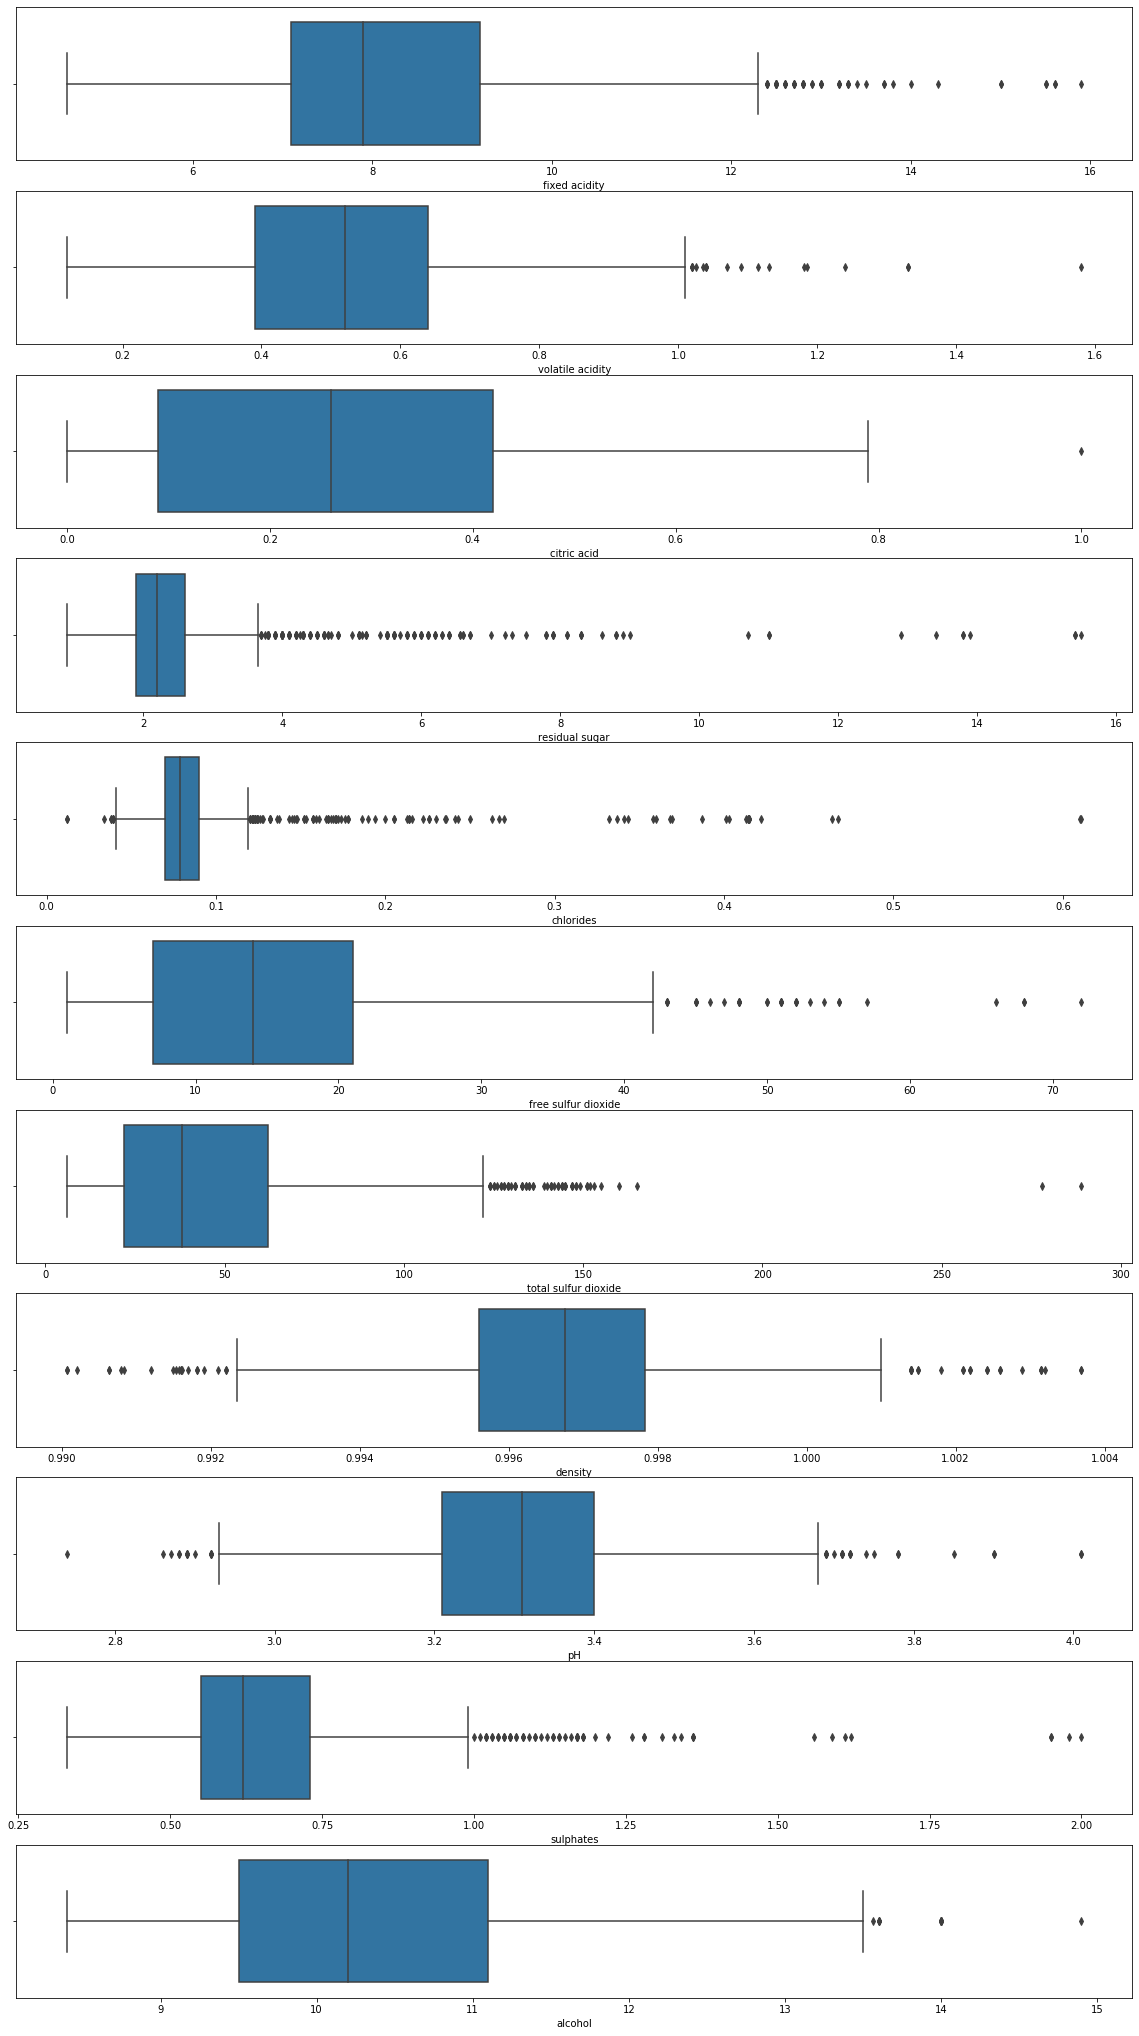

In [11]:
plt.figure(figsize = (20,40))
for i, c in enumerate(feature_names):
    plt.subplot(12,1,i+1)
    sns.boxplot(wine_quality_df[c])

In [12]:
for f in feature_names:
    q1 = wine_quality_df.describe()[f]["25%"]
    q3 = wine_quality_df.describe()[f]["75%"]
    iqr = q3 - q1
    threshold_min = q1 - iqr * 1.5
    threshold_max = q3 + iqr * 1.5
    wine_quality_df[wine_quality_df[f] < threshold_min] = None
    wine_quality_df[wine_quality_df[f] > threshold_max] = None

In [13]:
wine_quality_df = wine_quality_df.dropna()
print(wine_quality_df.shape)
wine_quality_df.head(10)

(1135, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5.0
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5.0
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7.0
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7.0
10,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,5.0


In [14]:
wine_quality_df = wine_quality_df.reset_index(drop = True)
df = pd.DataFrame(min_max_scaler.fit_transform(wine_quality_df[feature_names]), columns = feature_names)
df = pd.concat([df, pd.DataFrame(wine_quality_df["quality"], columns=["quality"])], axis=1)
print(df.shape)
df.head(10)

(1135, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.319444,0.655367,0.000000,0.291667,0.459459,0.256410,0.261682,0.668367,0.757143,0.377049,0.162791,5.0
1,0.375000,0.858757,0.000000,0.583333,0.756757,0.615385,0.570093,0.540816,0.314286,0.573770,0.255814,5.0
2,0.375000,0.723164,0.054795,0.458333,0.675676,0.358974,0.448598,0.566327,0.400000,0.524590,0.255814,5.0
3,0.847222,0.180791,0.767123,0.291667,0.445946,0.410256,0.504673,0.693878,0.257143,0.409836,0.255814,6.0
4,0.319444,0.655367,0.000000,0.291667,0.459459,0.256410,0.261682,0.668367,0.757143,0.377049,0.162791,5.0
5,0.319444,0.610169,0.000000,0.250000,0.445946,0.307692,0.317757,0.668367,0.757143,0.377049,0.162791,5.0
6,0.388889,0.542373,0.082192,0.166667,0.364865,0.358974,0.495327,0.489796,0.457143,0.213115,0.162791,5.0
7,0.305556,0.598870,0.000000,0.000000,0.310811,0.358974,0.140187,0.260204,0.585714,0.229508,0.302326,7.0
8,0.375000,0.519774,0.027397,0.333333,0.418919,0.205128,0.112150,0.540816,0.542857,0.393443,0.186047,7.0
9,0.222222,0.519774,0.109589,0.250000,0.743243,0.358974,0.551402,0.426020,0.428571,0.344262,0.116279,5.0


# 処理前のSVC
Cross-Validation scores: [0.70535714 0.82142857 0.67857143 0.71875    0.56950673]

Average score: 0.6987227738629085

Test score: 0.5895833333333333

# 正規化・外れ値除去後

In [15]:
X_train, X_test, y_train, y_test = train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((794, 11), (341, 11))

In [16]:
cross_validation(svm_clf)

Cross-Validation scores: [0.6918239  0.44025157 0.49056604 0.5408805  0.78481013]
Average score: 0.589666427832179
Test score: 0.5659824046920822


# 特徴量選択
単一の特徴量でスコアを計測し最も良い物をどんどん選んでいく

In [17]:
def new_cross_validation(model, X_tr, y_tr):
    scores = cross_val_score(model, X_tr, y_tr, cv=kfold, 
                             scoring=make_scorer(mean_squared_error))
    return np.mean(scores)

In [18]:
import copy
best_feature_names = []
new_feature_names = []
max_score = 999
while feature_names != []:
    one_feature_max_score = 999
    for f in feature_names:
        X_tr, X_te, y_tr, y_te = train_test_split(wine_quality_df[f], wine_quality_df["quality"], test_size=0.3, random_state=0)
        X_tr = X_tr.to_numpy().reshape([len(X_tr), 1])
        score = new_cross_validation(svm_clf, X_tr, y_tr)
        if score < one_feature_max_score:
            one_feature_max_score = score
            best_one_feature_name = f
    new_feature_names.append(best_one_feature_name)
    feature_names.remove(best_one_feature_name)
    X_tr, X_te, y_tr, y_te = train_test_split(wine_quality_df[new_feature_names], wine_quality_df["quality"], test_size=0.3, random_state=0)
    score = new_cross_validation(svm_clf, X_tr, y_tr)
    if score < max_score:
        max_score = score
        best_feature_names = copy.copy(new_feature_names)
    else:
        break
print(best_feature_names, max_score)

['alcohol', 'sulphates', 'volatile acidity', 'citric acid'] 0.4963139877398296


In [19]:
feature_names = best_feature_names
X_train, X_test, y_train, y_test = train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((794, 4), (341, 4))

# 特徴量選択後

元のSVCのスコア

Cross-Validation scores: [0.70535714 0.82142857 0.67857143 0.71875    0.56950673]

Average score: 0.6987227738629085

Test score: 0.5895833333333333

In [20]:
cross_validation(svm_clf)

Cross-Validation scores: [0.55974843 0.43396226 0.43396226 0.48427673 0.56962025]
Average score: 0.4963139877398296
Test score: 0.4780058651026393


# 感想とか考察とか

正規化と外れ値除去の影響は微妙でした。

アルコール, 硫酸塩, 揮発性酸塩, クエン酸にさらに特徴量加えるとスコアが悪くなりました。

どれもワインの評価に重要らしいです。アルコールによって味の質感が変わり、硫酸塩はワインの酸化を防ぎ、揮発性酸塩は多いと臭みになり、クエン酸はワインの風味に影響するそうです。ワイン好きじゃないのでよくわからないです。

外れ値除去の代わりに平均値とかを当てはめるとどうなるかは検証してないです。一回当てはめたらmseのスコア出すところでエラーが出るのでやめました。

途中までスコアが高いほうが良いと思って書いてたので沼にはまりました。あと list = list だと参照渡しになるのも知らなくて沼にはまりました。